In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.causalpfn import ATEEstimator
from functools import reduce

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## MAIN HYPERPARAMETER
# N_DISC = 17, 19 were seen to be the worst, so I won't go higher than 16
N_DISC_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [3]:
# Discretization function
def discretize_treatment(T: np.ndarray, N: int) -> np.ndarray:
    """Returns discretized version of T. Assumes range of T is [0, 1].

    Args:
        T (np.ndarray): The raw treatment data 
        N (int): The number of discretized treatment values to use

    Returns:
        np.ndarray: The discretized treatment data
    """
    dt = 1 / (N - 1)
    T_discrete = np.round(np.array(T, dtype=np.float32) / dt) * dt

    return T_discrete

# RMSE function
def calculate_rmse(y_pred, y_true):
    result = np.mean(np.power(y_pred - y_true, 2))
    result = np.sqrt(result)

    return result

In [4]:
## Synthetic data generation

# Generate synthetic data, using the DGP from Vahid's paper - nonlinear backdoor
np.random.seed(42)
n, d = 2000, 1
X = np.random.normal(2, 1, size=(n, d)).astype(np.float32)
T = (0.1 * X[:, 0] ** 2 - X[:, 0] + np.random.normal(1, 2, size=n)).astype(np.float32)
T = T - T.min() # Rescale
T = T / T.max() # Rescale
Y = (0.5 * T ** 2 - T * X[:, 0] + np.random.normal(0, 2, size=n)).astype(np.float32)
def drf(t): return 0.5 * t ** 2 - 2 * t # true dose-response funcion

df = pd.concat([
    pd.DataFrame(data=X, columns=["x"]), 
    pd.DataFrame(data=T, columns=["T"]), 
    pd.DataFrame(data=Y, columns=["Y"])
    ], axis=1)

In [5]:
## Main prediction loop. Takes about 6 minutes to run.
list_of_ates = [] # [(N_DISC, ates)]

for N_DISC in N_DISC_VALUES:
    print(f"N_DISC: {N_DISC}")
    discrete_treatment_levels = np.linspace(0, 1, N_DISC)
    T_discrete = discretize_treatment(T, N_DISC)
    ates = []
    for i, t in enumerate(discrete_treatment_levels[:-1]):
        t0, t1 = discrete_treatment_levels[i], discrete_treatment_levels[i + 1]
        ids = (np.abs(T_discrete - t0) < 1e-4) | (np.abs(T_discrete - t1) < 1e-4)
        T_temp = np.where(np.abs(T_discrete[ids] - t0) < 1e-4, 0, 1).astype(np.float32)
        X_temp = X[ids].astype(np.float32).reshape(-1, 1)
        Y_temp = Y[ids].astype(np.float32)
        causalpfn_ate = ATEEstimator(
            device=device,
            verbose=False
        )
        causalpfn_ate.fit(X_temp, T_temp, Y_temp)
        ate = causalpfn_ate.estimate_ate()
        ates.append(ate)
    list_of_ates.append((N_DISC, ates))


N_DISC: 2
N_DISC: 3
N_DISC: 4
N_DISC: 5
N_DISC: 6
N_DISC: 7
N_DISC: 8
N_DISC: 9
N_DISC: 10


In [6]:
# To get a good RMSE estimate for all the predictions, need a large mesh
fine_mesh = np.linspace(0, 1, 100) # fixed, fine mesh
t_mesh = [np.linspace(0, 1, N_DISC) for N_DISC in N_DISC_VALUES] # to ensure all discrete treatment values are hit
t_mesh += [fine_mesh]
t_mesh = reduce(np.union1d, tuple(t_mesh))

# Get RMSE by evaluating on each of the t_mesh points
rmse_dict = dict()
y_true = drf(t_mesh)
for N_DISC, ates in list_of_ates:
    epos = [sum(ates[:i]) for i in range(N_DISC)]
    y_pred = np.interp(t_mesh, np.linspace(0, 1, N_DISC), epos)
    error = calculate_rmse(y_pred, y_true)
    rmse_dict[N_DISC] = np.round(error, 4)

# Create dataframe
df = pd.DataFrame.from_dict(rmse_dict, orient="index", columns=["RMSE"])
df

,RMSE
2,0.8222
3,0.7168
4,0.5789
5,0.4067
6,0.4065
7,0.5615
8,0.6103
9,0.8171
10,0.5642


<Axes: title={'center': 'RMSE of different choices of N_DISC'}, xlabel='N_DISC', ylabel='RMSE'>

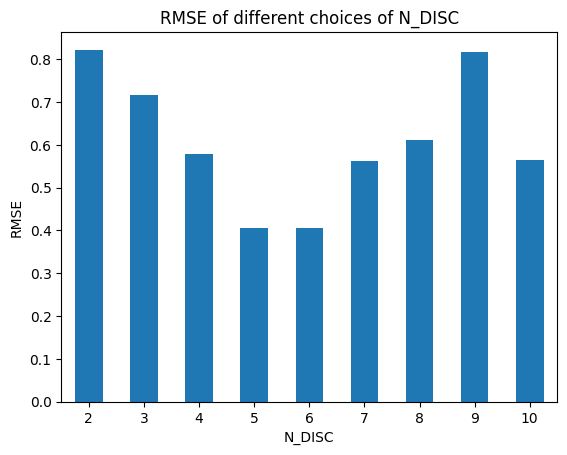

In [7]:
df.plot.bar(rot=0, title="RMSE of different choices of N_DISC", xlabel="N_DISC", ylabel="RMSE", legend=False)

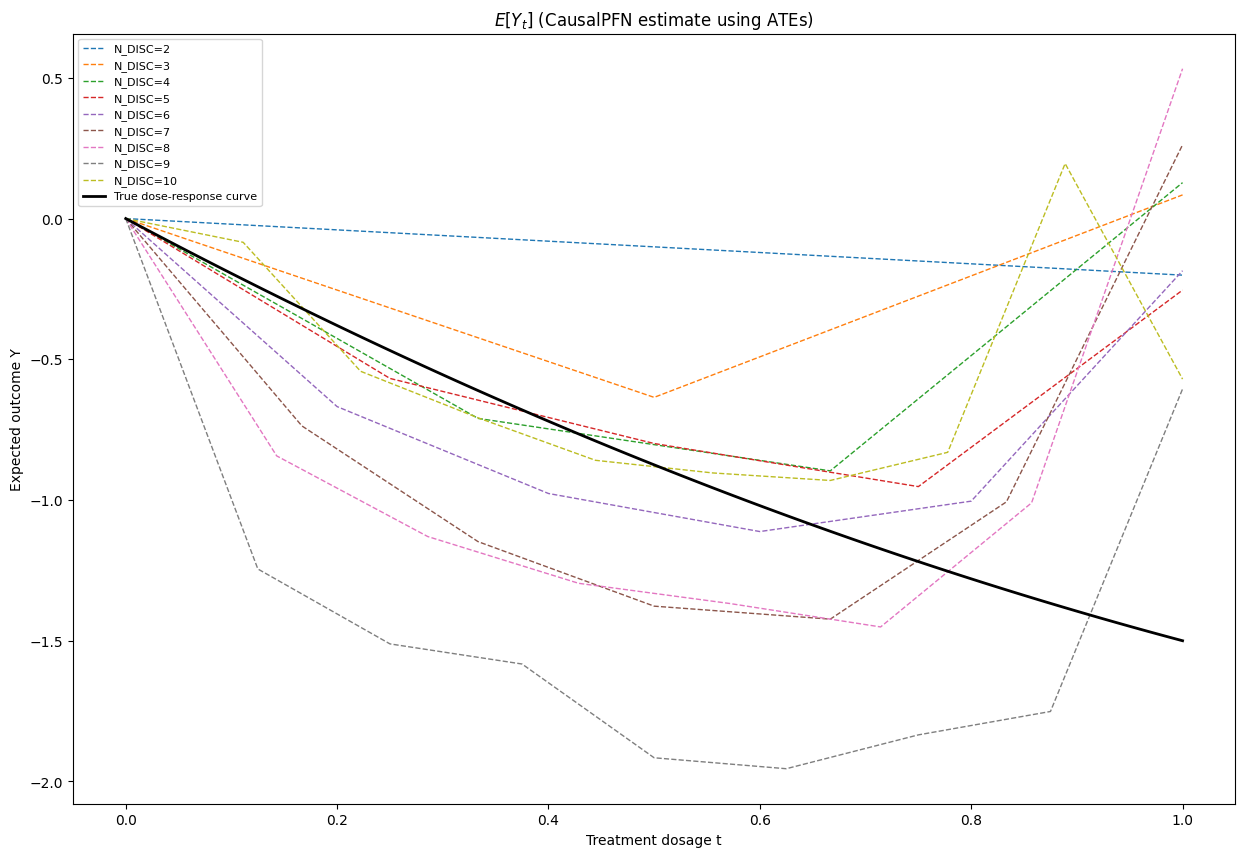

In [ ]:
fig = plt.figure(figsize=(15, 10))

# Plot predictions
i = 0 # counter for visual effects
for N_DISC, ates in list_of_ates:
    epos = [sum(ates[:i]) for i in range(N_DISC)]
    if df.loc[N_DISC, "RMSE"] == df.min().values: # Emphasize best prediction
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos, '-', linewidth=2,
                 label=f"N_DISC={N_DISC} (Best)", c="blue", zorder=14)
    else:
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos, '--', linewidth=1,
                 label=f"N_DISC={N_DISC}")
    i += 1

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ (CausalPFN estimate using ATEs)") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")

plt.legend(fontsize=8)
plt.show()